# Training on food-101

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import re
import os
import PIL

from pathlib import Path

from fastai.vision import *
from fastai.widgets import *
from fastai.callbacks import *

# Understanding the structure of the data

I'm going to be using the fastai library and following their general recommended approach for image classification, but first I need to look at the dataset and see what I'm working with.

In [4]:
path = Path('.')
!ls {path}

0food.ipynb		  edits2.csv	  images
base2.csv		  edits.csv	  images_split
cleaned2.csv		  food-101.tar	  license_agreement.txt
cleaned.csv		  food2.ipynb	  meta
cleaned_old.csv		  food-all.ipynb  models
cleaned_train_test_1.csv  food.ipynb	  README.txt
df1.csv			  history.csv	  setup-food.ipynb


In [12]:
!ls {path}/'meta'

classes.txt  labels.txt  test.json  test.txt  train.json  train.txt


In [13]:
traindf = pd.read_csv('meta/train.txt', delimiter='/', header=None, names=['Category', 'Image'])

In [14]:
traindf.head()

,Category,Image
0,apple_pie,1005649
1,apple_pie,1014775
2,apple_pie,1026328
3,apple_pie,1028787
4,apple_pie,1043283


In [15]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75750 entries, 0 to 75749
Data columns (total 2 columns):
Category    75750 non-null object
Image       75750 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [16]:
traindf.describe()

,Image
count,7.575000e+04
mean,1.864864e+06
std,1.149176e+06
min,5.300000e+01
25%,8.362325e+05
50%,1.836550e+06
75%,2.853988e+06
max,3.924720e+06


In [18]:
traindf['Category'].value_counts().describe()

count    101.0
mean     750.0
std        0.0
min      750.0
25%      750.0
50%      750.0
75%      750.0
max      750.0
Name: Category, dtype: float64

It looks like there are 750 images per category in the training set, which is what I expected based on the blurb on the website.

In [20]:
testdf = pd.read_csv('meta/test.txt', delimiter='/', names=['Category', 'Image'])

In [21]:
testdf.head()

,Category,Image
0,apple_pie,1011328
1,apple_pie,101251
2,apple_pie,1034399
3,apple_pie,103801
4,apple_pie,1038694


In [22]:
testdf['Category'].value_counts().describe()

count    101.0
mean     250.0
std        0.0
min      250.0
25%      250.0
50%      250.0
75%      250.0
max      250.0
Name: Category, dtype: float64

It looks like there are also 250 test images per category.

Now to look at an image:

In [6]:
!ls {path}/'images/apple_pie'

1005649.jpg  1596752.jpg  2298862.jpg  2764778.jpg  3299260.jpg  437455.jpg
1011328.jpg  1617515.jpg  2302866.jpg  2766011.jpg  330431.jpg	 438094.jpg
101251.jpg   1617793.jpg  2303859.jpg  2766017.jpg  3307686.jpg  440497.jpg
1014775.jpg  1620714.jpg  2304784.jpg  2766379.jpg  3313267.jpg  451719.jpg
1026328.jpg  1622276.jpg  2306493.jpg  2766609.jpg  3314985.jpg  455977.jpg
1028787.jpg  1626685.jpg  2320000.jpg  2766725.jpg  3318370.jpg  456190.jpg
1034399.jpg  1629072.jpg  2323355.jpg  2767057.jpg  3324492.jpg  456934.jpg
103801.jpg   1633183.jpg  2328227.jpg  2768268.jpg  3327221.jpg  466304.jpg
1038694.jpg  1633812.jpg  2334907.jpg  2769307.jpg  3330808.jpg  471995.jpg
1043283.jpg  1646808.jpg  2335873.jpg  2769368.jpg  3333030.jpg  481805.jpg
1047447.jpg  1648647.jpg  2337097.jpg  2769470.jpg  3335126.jpg  483621.jpg
1050519.jpg  1657587.jpg  2337652.jpg  2776008.jpg  333800.jpg	 484038.jpg
1057749.jpg  1659828.jpg  2338398.jpg  2777088.jpg  3349423.jpg  484947.jpg
1057810.jpg  1

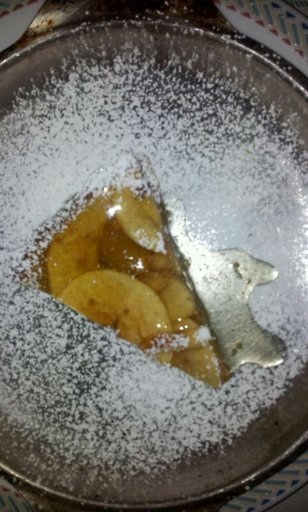

In [8]:
im = open_image(path/'images/apple_pie/1005649.jpg')
im

How big are the images?

In [9]:
im.size

torch.Size([512, 308])

function to get the size for each image based on a row of the train or test dataframes:

In [26]:
def get_size(row):
    category = row['Category']
    imagenum = row['Image']
    impath = Path('images/' + category + '/' + str(imagenum) + ".jpg")
    return PIL.Image.open(impath).size

In [27]:
testdf['Size'] = testdf.apply(get_size, axis=1)

In [28]:
testdf.head()

,Category,Image,Size
0,apple_pie,1011328,"(512, 512)"
1,apple_pie,101251,"(384, 512)"
2,apple_pie,1034399,"(384, 512)"
3,apple_pie,103801,"(382, 512)"
4,apple_pie,1038694,"(512, 342)"


In [29]:
traindf['Size'] = traindf.apply(get_size, axis=1)

Text(0.5, 1.0, 'Training set image sizes')

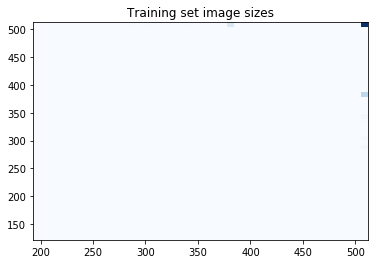

In [37]:
plt.hist2d(traindf['Size'].apply(lambda x: x[0]), traindf['Size'].apply(lambda x: x[1]), bins=50, cmap='Blues')
plt.title('Training set image sizes')

Text(0, 0.5, 'counts')

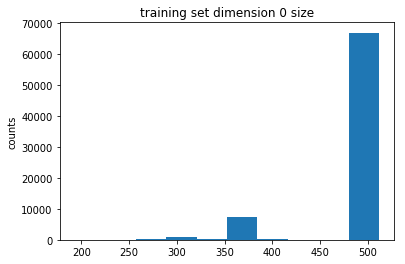

In [41]:
plt.hist(traindf['Size'].apply(lambda x: x[0]))
plt.title('training set dimension 0 size')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

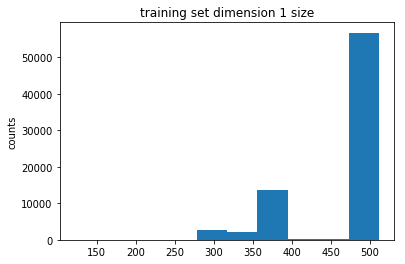

In [42]:
plt.hist(traindf['Size'].apply(lambda x: x[1]))
plt.title('training set dimension 1 size')
plt.ylabel('counts')

Text(0.5, 1.0, 'Test set image sizes')

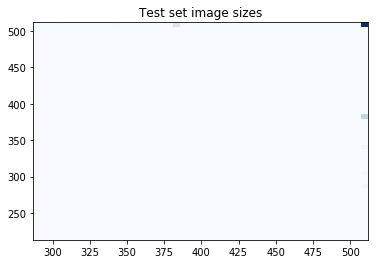

In [35]:
plt.hist2d(testdf['Size'].apply(lambda x: x[0]), testdf['Size'].apply(lambda x: x[1]), bins=50, cmap='Blues')
plt.title('Test set image sizes')

Text(0, 0.5, 'counts')

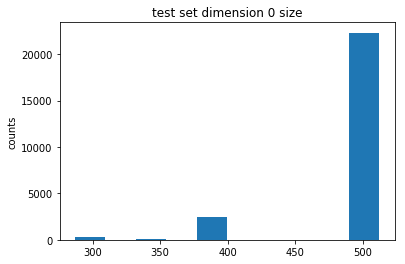

In [44]:
plt.hist(testdf['Size'].apply(lambda x: x[0]))
plt.title('test set dimension 0 size')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

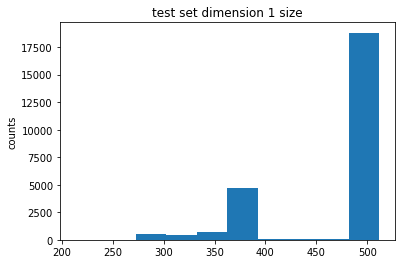

In [46]:
plt.hist(testdf['Size'].apply(lambda x: x[1]))
plt.title('test set dimension 1 size')
plt.ylabel('counts')

It looks like the majority of the images are 512x512, with some smaller ones (especially in the test set).

# Setting up the data for training
I originally started off by moving the files into an ImageNet-style organization, but this ended up creating complications later on when I had to relabel some of the training images.  I decided it would be easier to have one dataframe with all the info for the training and validation sets: where the images are located, what the label is, and whether the image belongs in the training set or the validation set.

In [47]:
traindf = pd.read_csv('meta/train.txt', names=['name'])

In [48]:
traindf.head()

,name
0,apple_pie/1005649
1,apple_pie/1014775
2,apple_pie/1026328
3,apple_pie/1028787
4,apple_pie/1043283


In [49]:
traindf['label'] = traindf['name'].apply(lambda x: x.split('/')[0])

In [50]:
traindf['valid'] = False

In [51]:
traindf.head()

,name,label,valid
0,apple_pie/1005649,apple_pie,False
1,apple_pie/1014775,apple_pie,False
2,apple_pie/1026328,apple_pie,False
3,apple_pie/1028787,apple_pie,False
4,apple_pie/1043283,apple_pie,False


In [52]:
validdf = pd.read_csv('meta/test.txt', names=['name'])
validdf['label'] = validdf['name'].apply(lambda x: x.split('/')[0])
validdf['valid'] = True

In [53]:
validdf.head()

,name,label,valid
0,apple_pie/1011328,apple_pie,True
1,apple_pie/101251,apple_pie,True
2,apple_pie/1034399,apple_pie,True
3,apple_pie/103801,apple_pie,True
4,apple_pie/1038694,apple_pie,True


In [67]:
df = pd.concat([traindf, validdf], ignore_index=True)

In [69]:
df.head()

,name,label,valid
0,apple_pie/1005649,apple_pie,False
1,apple_pie/1014775,apple_pie,False
2,apple_pie/1026328,apple_pie,False
3,apple_pie/1028787,apple_pie,False
4,apple_pie/1043283,apple_pie,False


In [68]:
df.tail()

,name,label,valid
100995,waffles/942009,waffles,True
100996,waffles/954028,waffles,True
100997,waffles/96181,waffles,True
100998,waffles/97015,waffles,True
100999,waffles/971843,waffles,True


# General strategies: ResNet-50 and resizing images

When I've done image classification previously, I've found a big benefit from progressive resizing of the images -- I start off training on smaller versions and gradually increase the size.  It makes sense that this would help because it's essentially a form of data augmentation.  When choosing the architecture, I decided to use a ResNet-50 because in the past I've found that bigger networks tend to do better, especially with lots of classes, and because the problem statement says to use ResNet-50 or smaller.

In [10]:
bs = 64 # batch size

The ImageItemList is a way to specify a databunch.  The inputs are found in the dataframe df with the labels being located in the 'label' column.  I'm splitting out the validation set based on the value of the 'valid' column.  I'm also applying fastai's built-in set of data augmentation and resizing the images to be 64x64. 

In [11]:
data = (ImageItemList.from_df(df, path, cols='name', folder='images', suffix='.jpg')
        .split_from_df(col='valid')
        .label_from_df(cols='label')
        .transform(get_transforms(), size=64)
        .databunch()).normalize(imagenet_stats)

Having assembled the data, I want to sanity check myself and make sure everything looks like I expect it to.

In [35]:
data.batch_size

64

In [36]:
data.train_ds

LabelList
y: CategoryList (75750 items)
[Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie]...
Path: .
x: ImageItemList (75750 items)
[Image (3, 512, 308), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: .

In [37]:
data.valid_ds

LabelList
y: CategoryList (25250 items)
[Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie]...
Path: .
x: ImageItemList (25250 items)
[Image (3, 512, 512), Image (3, 512, 384), Image (3, 512, 384), Image (3, 512, 382), Image (3, 342, 512)]...
Path: .

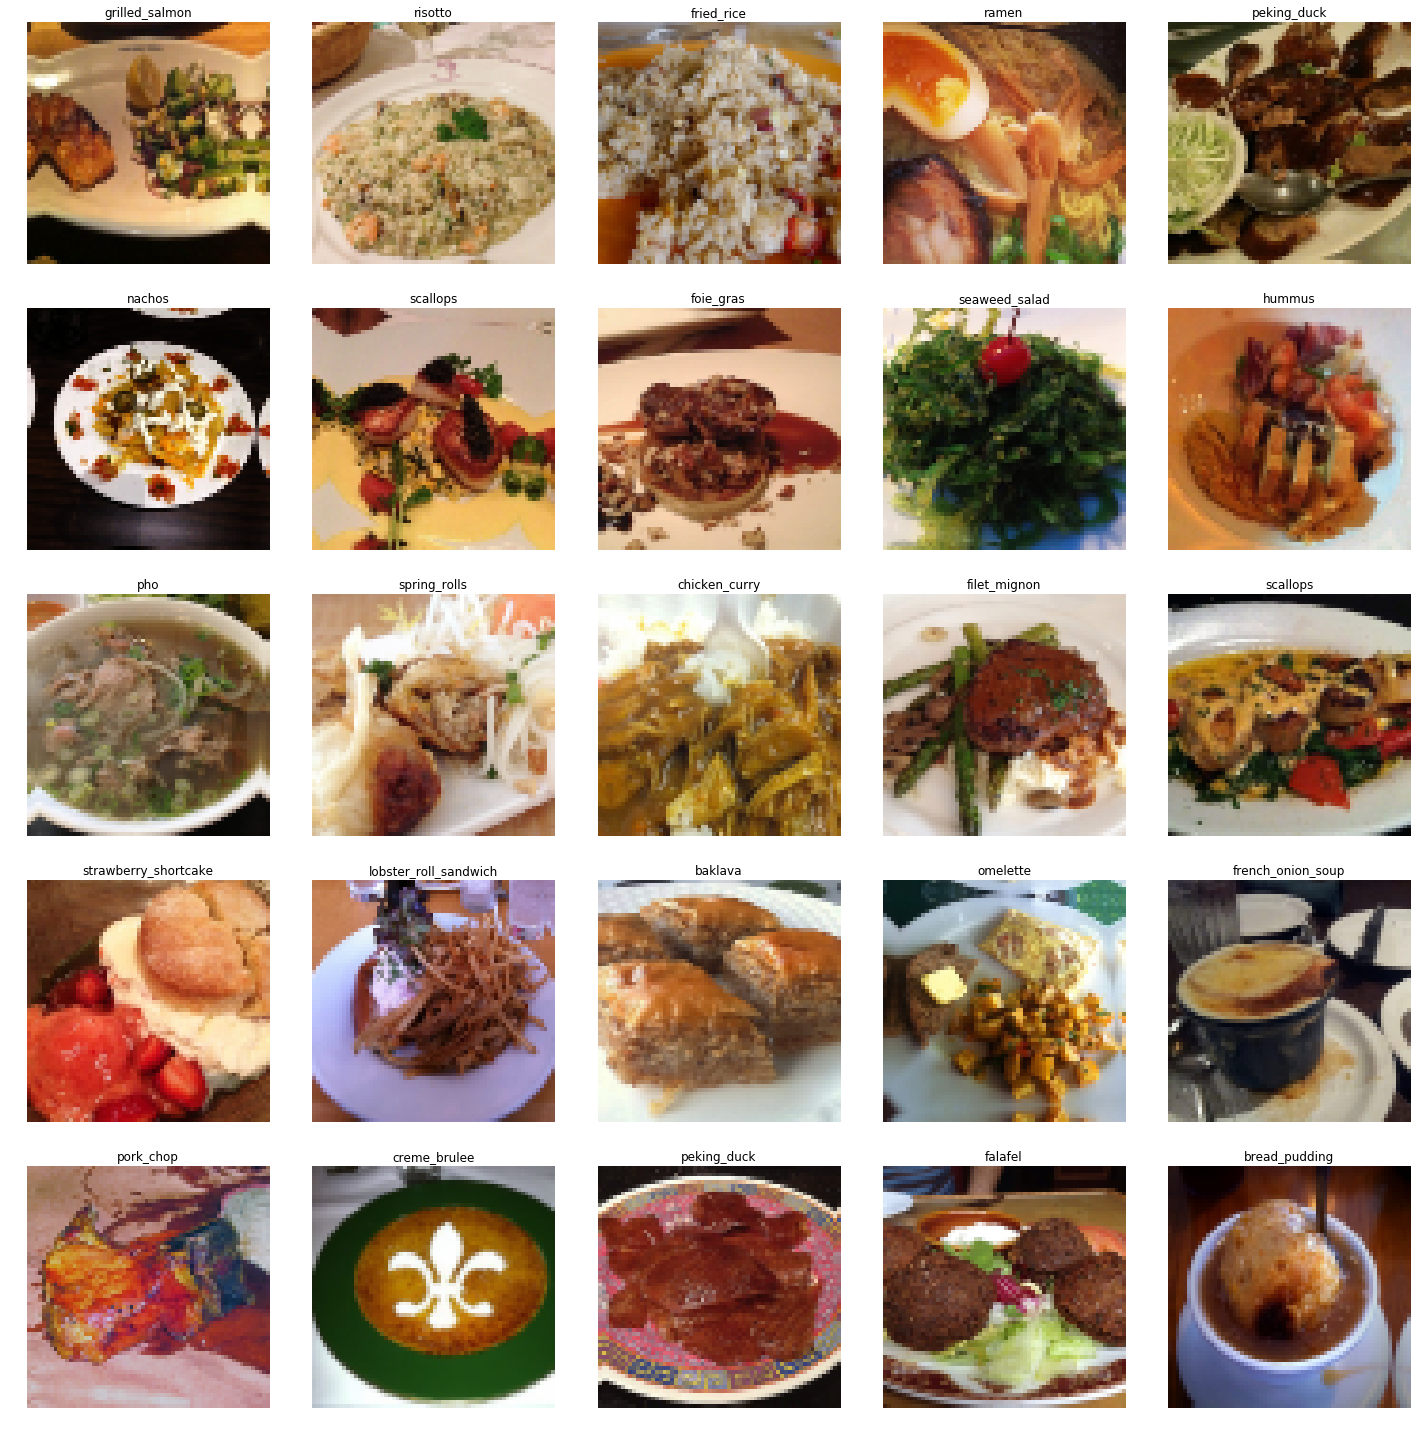

In [40]:
data.show_batch()

In [42]:
print(data.classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [43]:
len(data.classes)

101

# Things look good -- ready to train!

Finally, I create a CNN learner with the ResNet-50 architecture.  By default, the model is pretrained on ImageNet.  This is what I want since food-101 and ImageNet have a lot of features in common and I can use transfer learning to be more efficient with training.

In [12]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [45]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

fastai includes a handy tool for finding a good learning rate.  The idea is to look at the loss as a function of learning rate, and to choose a learning rate at or slightly smaller than where the loss is decreasing most rapidly.

In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


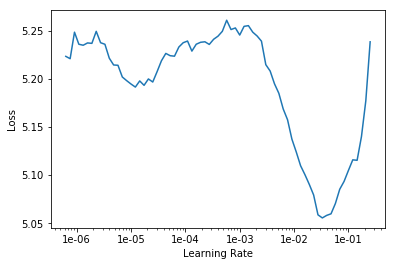

In [48]:
learn.recorder.plot(skip_end=10)

I'm training according to Leslie Smith's OneCycle policy.  It's a procedure for varying learning rate and momentum in a way that accelerates convergence.

In [49]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,2.954396,2.540046,0.363960
2,2.922645,2.573929,0.354416
3,2.866682,2.498236,0.373069
4,2.696377,2.317290,0.407287
5,2.626982,2.128846,0.454416
6,2.494871,1.982326,0.490337
7,2.325205,1.869250,0.511010
8,2.201820,1.766447,0.540990
9,2.115020,1.701308,0.554653
10,2.048005,1.692274,0.558020


In [51]:
learn.save('food1')

Next, I'm going to unfreeze not only the final layers of the model but also some earlier ones to fine-tune more of the weights.

In [52]:
learn.freeze_to(-1)

In [53]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,2.124578,1.751064,0.541980
2,2.440057,2.055513,0.469505
3,2.577488,2.193455,0.440673
4,2.557270,2.178755,0.440515
5,2.488826,1.998657,0.484950
6,2.363738,1.904805,0.505307
7,2.251378,1.801064,0.528515
8,2.120063,1.714258,0.550653
9,2.031353,1.662351,0.563208
10,2.062240,1.656528,0.566337


In [54]:
learn.save('food1_1')

Unfreezing even more layers and training some more:

In [55]:
learn.freeze_to(-2)

In [56]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,2.804148,2.657277,0.337941
2,2.796161,2.550916,0.362218
3,2.806906,2.449047,0.381069
4,2.582628,2.242149,0.422376
5,2.450869,2.149822,0.452396
6,2.270529,1.863981,0.513663
7,2.029928,1.674391,0.560752
8,1.839911,1.556798,0.587168
9,1.725723,1.482820,0.605069
10,1.658688,1.471767,0.608594


In [57]:
learn.save('food1_2')

Now unfreezing all the layers:

In [58]:
learn.unfreeze()

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


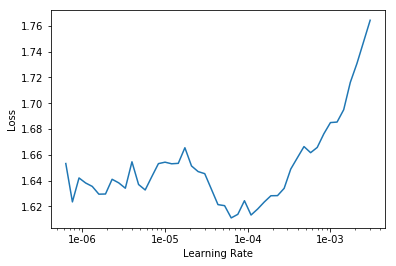

In [66]:
learn.recorder.plot(skip_end=30)

In [71]:
learn.fit_one_cycle(10, slice(1e-5, 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,1.599346,1.458102,0.611287
2,1.606191,1.458779,0.612554
3,1.633450,1.453849,0.612396
4,1.616040,1.452017,0.612317
5,1.563996,1.442198,0.616832
6,1.583156,1.440300,0.615327
7,1.560324,1.433570,0.617901
8,1.513476,1.430479,0.619287
9,1.556442,1.431020,0.619129
10,1.536547,1.429912,0.619604


In [72]:
learn.save('food1_all') 

# Looking at the top losses

The description of the dataset mentions that some of the training images were mislabelled, which suggested that some cleaning could improve performance.  I used fastai's ImageCleaner to look more closely at the images that had the highest losses.  The reasoning behind this is that if an image is mislabelled, we would expect the associated loss to be high.

In [14]:
ds, idxs = DatasetFormatter.from_toplosses(learn)

In [15]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

I found several mislabelled images and relabelled them as well as I could.  For example, I changed the label for this image from 'apple pie' to 'baby back ribs'.

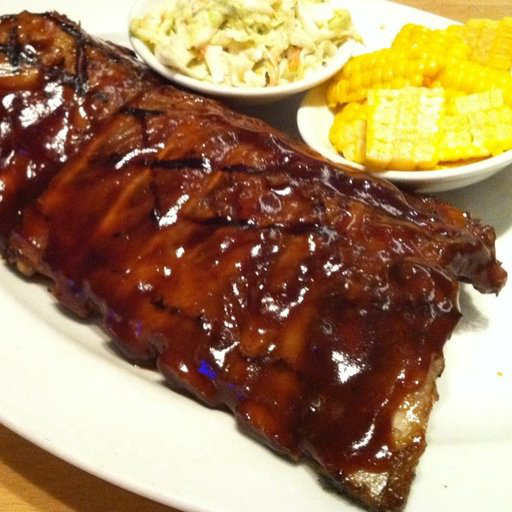

In [75]:
open_image(path/'images/apple_pie/1158360.jpg')

The way the ImageCleaner works is that it creates a .csv file containing the edits; it doesn't actually move (or delete, in the case of images that don't belong in the dataset at all) the images.  So when I wanted to pick up training again, I had to use the labels from this file instead of the dataframe I initially used.

In [4]:
df = pd.read_csv('cleaned2.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)
df.tail()

,name,label,valid
100913,waffles/942009.jpg,waffles,True
100914,waffles/954028.jpg,waffles,True
100915,waffles/96181.jpg,waffles,True
100916,waffles/97015.jpg,waffles,True
100917,waffles/971843.jpg,waffles,True


From this point, I basically repeated the same training process as before several times, starting with image size 64 and gradually increasing it.  I also added some additional data augmentation, and some callbacks to the learner to keep track of the losses and accuracy during training.  As I increased the image size, I also had to decrease the batch size because I was running out of memory.  

In [6]:
data = (ImageItemList.from_df(df, path, cols='name', folder='images')
        .split_from_df(col='valid')
        .label_from_df(cols='label')
        .transform(tfms=get_transforms(max_rotate=15.0, max_zoom=1.5, max_lighting=0.4, max_warp=0.4), size=64, padding_mode='reflection')
        .databunch(bs=bs)).normalize(imagenet_stats)

In [8]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, callback_fns=[SaveModelCallback, CSVLogger])

In [62]:
learn.load('food1_all')

...and repeated the training process for image sizes 64, 128, and 256.

# Image size 400

At this point, my progress had essentially stalled.

In [7]:
bs = 16 
data = (ImageItemList.from_df(df, path, cols='name', folder='images')
        .split_from_df(col='valid')
        .label_from_df(cols='label')
        .transform(tfms=get_transforms(max_rotate=15.0, max_zoom=1.5, max_lighting=0.4, max_warp=0.4), size=400, padding_mode='reflection')
        .databunch(bs=bs)).normalize(imagenet_stats)

In [8]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, callback_fns=[SaveModelCallback, CSVLogger])

In [10]:
learn.load('food3_all')

In [48]:
learn.fit_one_cycle(3, 1e-4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.841633,0.518075,0.856673
2,0.802212,0.512708,0.858178
3,0.744089,0.511938,0.859248


Better model found at epoch 1 with val_loss value: 0.518075168132782.
Better model found at epoch 2 with val_loss value: 0.5127081274986267.
Better model found at epoch 3 with val_loss value: 0.511938214302063.


   epoch  train_loss  valid_loss  accuracy
0      1    0.841633    0.518075  0.856673
1      2    0.802212    0.512708  0.858178
2      3    0.744089    0.511938  0.859248


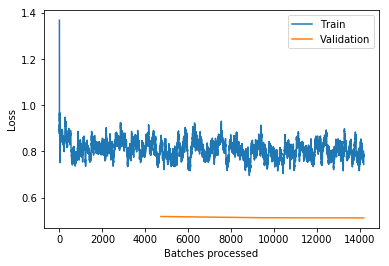

In [49]:
print(learn.csv_logger.read_logged_file())
learn.save('food6')
learn.recorder.plot_losses()

The flatness of the training loss gave me the idea that I might be regularizing too much, so I reduced the amount of data augmentation I was doing.

In [7]:
data = (ImageItemList.from_df(df, path, cols='name', folder='images')
        .split_from_df(col='valid')
        .label_from_df(cols='label')
        .transform(tfms=get_transforms(), size=400, padding_mode='reflection')
        .databunch(bs=bs)).normalize(imagenet_stats)

In [8]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, callback_fns=[SaveModelCallback, CSVLogger])

In [10]:
learn.load('food6')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


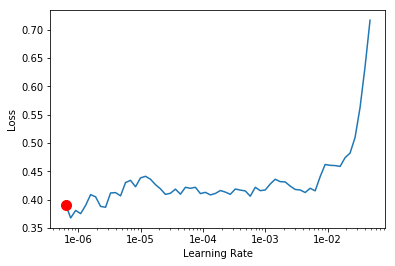

In [11]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot()

In [76]:
learn.fit_one_cycle(10, 3e-4, moms=(0.8, 0.7))
learn.save('food6a') #.51 .5 0.864

In [12]:
learn.freeze_to(-1)
learn.fit_one_cycle(3, slice(1e-6, 1e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.578356,0.504407,0.862376
2,0.546652,0.504785,0.862535
3,0.515387,0.502180,0.862455


Better model found at epoch 1 with val_loss value: 0.5044074058532715.
Better model found at epoch 3 with val_loss value: 0.5021799802780151.


In [14]:
learn.save('food6_1')
print(learn.csv_logger.read_logged_file()) 

   epoch  train_loss  valid_loss  accuracy
0      1    0.578356    0.504407  0.862376
1      2    0.546652    0.504785  0.862535
2      3    0.515387    0.502180  0.862455


In [17]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


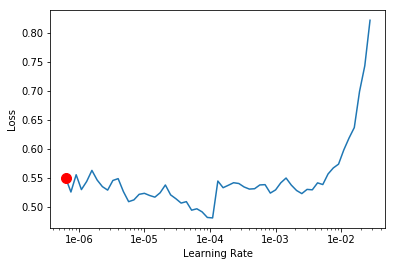

In [18]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, np.array([1e-6, 1e-5, 1e-4]), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.499765,0.503527,0.861624
2,0.560036,0.502015,0.862693
3,0.547452,0.505969,0.862059
4,0.544698,0.501108,0.861822


Better model found at epoch 1 with val_loss value: 0.5035268664360046.
Better model found at epoch 2 with val_loss value: 0.5020154118537903.
Better model found at epoch 4 with val_loss value: 0.5011084675788879.


My intention was to additionally use full-sized images, but unfortunately it's still training at the time of writing, so I'm just going to submit my results trained on images up to 400x400.  To see how well I'm doing at this point, I'll look at my accuracy on predictions with TTA applied, since that's the evaluation metric requested in the problem description:

In [14]:
yp, y = learn.TTA(scale=1.1)

In [15]:
accuracy(yp, y)

tensor(0.8677)